<a href="https://colab.research.google.com/github/KSeungBin/yeardream_CV_project/blob/main/border_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%cd /content/drive/MyDrive/기업연계프로젝트/Datasets
!unzip -qq '/content/drive/MyDrive/기업연계프로젝트/Datasets/Datasets.zip'

/content/drive/MyDrive/기업연계프로젝트/Datasets


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os

path = "/content/drive/MyDrive/Colab Notebooks/data/Datasets2/Train/images"
file_list = os.listdir(path)
len(file_list)

635

In [5]:
!pip install segmentation-models-pytorch
!pip install pytorch-lightning
!pip install torchtext
!pip install adamp
!pip install wandb
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 97 kB 6.6 MB/s 
     |████████████████████████████████| 376 kB 54.2 MB/s 
     |████████████████████████████████| 58 kB 6.0 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=f95cc3b9fb0eb8568a4b9496c73cc15322867fbe37a41264c71a4a2976737d2c
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=3d16647f54347db4da92fec5f9108454a26d251e173c46c222f63e42d9de96e9
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |███████

In [6]:
import os 
import cv2
import torch
import torchvision
import PIL
import wandb
import natsort

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
import torch.optim.lr_scheduler as lr_scheduler

from adamp import AdamP
from torchmetrics.functional import jaccard_index, accuracy, f1_score, precision, recall
from glob import glob
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset
from tqdm.autonotebook import tqdm
from sklearn.model_selection import train_test_split
from ipywidgets import interact
from torchvision.transforms.functional import to_pil_image
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from pytorch_lightning.loggers import WandbLogger

pl.seed_everything(42)

INFO:pytorch_lightning.utilities.seed:Global seed set to 42


42

In [7]:
image_dir = "/content/drive/MyDrive/Colab Notebooks/data/Datasets2/Train/images/"
mask_dir = "/content/drive/MyDrive/Colab Notebooks/data/Datasets2/Train/masks/"

images_paths = glob(image_dir + "*.jpg")
masks_paths = glob(mask_dir + "*.png")

images_paths = natsort.natsorted(images_paths)
masks_paths = natsort.natsorted(masks_paths)
df = pd.DataFrame({'images': images_paths, 'masks': masks_paths})
df.head(5)

,images,masks
0,/content/drive/MyDrive/Colab Notebooks/data/Da...,/content/drive/MyDrive/Colab Notebooks/data/Da...
1,/content/drive/MyDrive/Colab Notebooks/data/Da...,/content/drive/MyDrive/Colab Notebooks/data/Da...
2,/content/drive/MyDrive/Colab Notebooks/data/Da...,/content/drive/MyDrive/Colab Notebooks/data/Da...
3,/content/drive/MyDrive/Colab Notebooks/data/Da...,/content/drive/MyDrive/Colab Notebooks/data/Da...
4,/content/drive/MyDrive/Colab Notebooks/data/Da...,/content/drive/MyDrive/Colab Notebooks/data/Da...


In [8]:
test_image_dir = "/content/drive/MyDrive/Colab Notebooks/data/Datasets2/Test/images/"
test_mask_dir = "/content/drive/MyDrive/Colab Notebooks/data/Datasets2/Test/masks/"

images_paths = glob(test_image_dir + "*.jpg")
masks_paths = glob(test_mask_dir + "*.png")

images_paths = natsort.natsorted(images_paths)
masks_paths =natsort.natsorted(masks_paths)

test_df = pd.DataFrame({'images': images_paths, 'masks': masks_paths})
test_df.head(5)

,images,masks
0,/content/drive/MyDrive/Colab Notebooks/data/Da...,/content/drive/MyDrive/Colab Notebooks/data/Da...
1,/content/drive/MyDrive/Colab Notebooks/data/Da...,/content/drive/MyDrive/Colab Notebooks/data/Da...
2,/content/drive/MyDrive/Colab Notebooks/data/Da...,/content/drive/MyDrive/Colab Notebooks/data/Da...
3,/content/drive/MyDrive/Colab Notebooks/data/Da...,/content/drive/MyDrive/Colab Notebooks/data/Da...
4,/content/drive/MyDrive/Colab Notebooks/data/Da...,/content/drive/MyDrive/Colab Notebooks/data/Da...


In [9]:
train, valid = train_test_split(df, test_size=0.1, shuffle=True, random_state=42)

print(f"Train size: {len(train)}, Validation size: {len(valid)}")

Train size: 571, Validation size: 64


In [10]:
@interact(index=(0, len(df)-1))
def show_images(index=0):
    image = cv2.imread(df.iloc[index].images)
    mask = cv2.imread(df.iloc[index].masks)

    plt.figure(figsize=(12,10))
    plt.subplot(121)
    plt.title("image")
    plt.imshow(image)
    plt.subplot(122)
    plt.title("mask")
    plt.imshow(mask)
    plt.tight_layout()

interactive(children=(IntSlider(value=0, description='index', max=634), Output()), _dom_classes=('widget-inter…

In [11]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [12]:
base_transform = [
    ToTensorV2()
]

train_transform = [
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=10, 
                       border_mode=cv2.BORDER_WRAP, p=0.5), 
    A.RandomRain(brightness_coefficient=0.9, drop_length=10, drop_width=1, blur_value=3, p=0.3),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, brightness_by_max=True, p=1),
    A.CLAHE(clip_limit=2, tile_grid_size=(8, 8), p=1),
    A.RandomCrop(width=320, height=320)
    ]

train_transform.extend(base_transform)
train_transform = A.Compose(train_transform)

test_transform = A.Compose(base_transform)

In [13]:
class SegmentationDataset(torch.utils.data.Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        image_path = self.df.iloc[index].images
        mask_path = self.df.iloc[index].masks

        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path, 0) // 255
        
        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            transformed_image = transformed['image'].float()
            transformed_mask = transformed['mask'].float()
        
        return transformed_image, transformed_mask

In [22]:
mask

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [14]:
ds = SegmentationDataset(df, train_transform)
test_ds = SegmentationDataset(test_df, test_transform)

In [15]:
@interact(index=(0, len(df)-1))
def show_images(index=0):
    img, mask = ds[index]
    plt.figure(figsize=(20,10))
    plt.axis=("off")
    plt.subplot(121)
    img = img.int()
    plt.imshow(img.permute(1,2,0))
    plt.subplot(122)
    plt.imshow(mask, cmap='gray')


interactive(children=(IntSlider(value=0, description='index', max=634), Output()), _dom_classes=('widget-inter…

In [16]:
class SegmentationModel(pl.LightningModule):
    def __init__(self, args=None, optimizer='adam', scheduler='reducelr'):
        super().__init__()
        self.model = smp.UnetPlusPlus(
            encoder_name='efficientnet-b0',  # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
            encoder_weights="imagenet",  # use `imagenet` pre-trained weights for encoder initialization
            in_channels=3,  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
            classes=2,  # model output channels (number of classes in your dataset)
        )
        self.args = args
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optimizer
        self.scheduler = scheduler

    def forward(self, x):
        x = self.model(x)
        return x

    def configure_optimizers(self):
        if self.optimizer == 'adam':
            optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        elif self.args.optimizer == 'adamw':
            optimizer = torch.optim.AdamW(self.parameters(), lr=0.001)
        elif self.args.optimizer == 'adamp':
            optimizer = AdamP(self.parameters(), lr=0.001, betas=(0.9, 0.999), weight_decay=1e-2)

        if self.scheduler == "reducelr":
            scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5, mode="max", verbose=True)
            return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val/jaccard_index_value"}

        elif self.args.scheduler == "cosineanneal":
            scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=1e-5,
                                                                 last_epoch=-1, verbose=True)

        return {"optimizer": optimizer, "lr_scheduler": scheduler}

    def training_step(self, train_batch, batch_idx):
        image, mask = train_batch
        mask = mask.long()

        outputs = self.model(image)
        loss = self.criterion(outputs, mask)
        jaccard_index_value = jaccard_index(outputs.argmax(dim=1), mask, num_classes=2)
        acc_value = accuracy(outputs.argmax(dim=1), mask)
        f1_value = f1_score(outputs.argmax(dim=1), mask, num_classes=2, mdmc_average='samplewise')
        precision_value = precision(outputs.argmax(dim=1), mask, average='micro', mdmc_average='samplewise')
        recall_value = recall(outputs.argmax(dim=1), mask, average='micro', mdmc_average='samplewise')

        self.log('train/loss', loss, on_epoch=True, on_step=True, prog_bar=True, sync_dist=True)
        self.log('train/acc', acc_value, on_epoch=True, on_step=True, prog_bar=True)
        self.log('train/jaccard_index_value', jaccard_index_value, on_epoch=True, on_step=True, prog_bar=True,
                 sync_dist=True)
        self.log('train/f1', f1_value, on_epoch=True, on_step=True, prog_bar=True, sync_dist=True)
        self.log('train/precision', precision_value, on_epoch=True, on_step=True, prog_bar=True, sync_dist=True)
        self.log('train/recall', recall_value, on_epoch=True, on_step=True, prog_bar=True, sync_dist=True)
        

        return {"loss": loss, "acc": acc_value, "jaccard_index": jaccard_index_value, "f1": f1_value, "precision": precision_value, "recall": recall_value}

    def validation_step(self, val_batch, batch_idx):
        image, mask = val_batch
        mask = mask.long()

        outputs = self.model(image)
        loss = self.criterion(outputs, mask)
        jaccard_index_value = jaccard_index(outputs.argmax(dim=1), mask, num_classes=2)
        acc_value = accuracy(outputs.argmax(dim=1), mask)
        f1_value = f1_score(outputs.argmax(dim=1), mask, num_classes=2, mdmc_average='samplewise')
        precision_value = precision(outputs.argmax(dim=1), mask, average='micro', mdmc_average='samplewise')
        recall_value = recall(outputs.argmax(dim=1), mask, average='micro', mdmc_average='samplewise')


        self.log('val/loss', loss, on_epoch=True, on_step=True, prog_bar=True, sync_dist=True)
        self.log('val/acc', acc_value, on_epoch=True, on_step=True, prog_bar=True)
        self.log('val/jaccard_index_value', jaccard_index_value, on_epoch=True, on_step=True, prog_bar=True,
                 sync_dist=True)
        self.log('val/f1', f1_value, on_epoch=True, on_step=True, prog_bar=True, sync_dist=True)
        self.log('val/precision', precision_value, on_epoch=True, on_step=True, prog_bar=True, sync_dist=True)
        self.log('val/recall', recall_value, on_epoch=True, on_step=True, prog_bar=True, sync_dist=True)
        

        return {"loss": loss, "acc": acc_value, "jaccard_index": jaccard_index_value, "f1": f1_value, "precision": precision_value, "recall": recall_value}

    def test_step(self, test_batch, batch_idx):
        image, mask = test_batch
        mask = mask.long()

        outputs = self.model(image)
        loss = self.criterion(outputs, mask)
        jaccard_index_value = jaccard_index(outputs.argmax(dim=1), mask, num_classes=2)
        acc_value = accuracy(outputs.argmax(dim=1), mask)
        f1_value = f1_score(outputs.argmax(dim=1), mask, num_classes=2, mdmc_average='samplewise')
        precision_value = precision(outputs.argmax(dim=1), mask, average='micro', mdmc_average='samplewise')
        recall_value = recall(outputs.argmax(dim=1), mask, average='micro', mdmc_average='samplewise')


        self.log('test/loss', loss, on_epoch=True, on_step=False, prog_bar=True, sync_dist=True)
        self.log('test/acc', acc_value, on_epoch=True, on_step=False, prog_bar=True)
        self.log('test/jaccard_index_value', jaccard_index_value, on_epoch=True, on_step=False, prog_bar=True,
                 sync_dist=True)
        self.log('test/f1', f1_value, on_epoch=True, on_step=False, prog_bar=True, sync_dist=True)
        self.log('test/precision', precision_value, on_epoch=True, on_step=False, prog_bar=True, sync_dist=True)
        self.log('test/recall', recall_value, on_epoch=True, on_step=False, prog_bar=True, sync_dist=True)

        return {"loss": loss, "acc": acc_value, "jaccard_index": jaccard_index_value, "f1": f1_value, "precision": precision_value, "recall": recall_value}


In [16]:
kf = KFold(n_splits=5)
for idx, (train_index, val_index) in enumerate(kf.split(X=train['images'])):
    wandb_logger = WandbLogger(project="border_check", name=f'5_fold{idx + 1:02d}', entity="crack_detection_22")
    checkpoint_callback = ModelCheckpoint(
            monitor="val/jaccard_index_value",
            dirpath="/content/drive/MyDrive/Colab Notebooks/data/checkpoints",
            filename=f"unet++_fold{idx + 1:02d}_" + "{val/jaccard_index_value:.4f}",
            save_top_k=3,
            mode="max",
            # save_weights_only=True
        )

    early_stop_callback = EarlyStopping(monitor="val/loss", min_delta=0.00, patience=50, verbose=True,
                                            mode="min")
    model = SegmentationModel()

    train_ds = SegmentationDataset(train, train_transform)
    train_dataloader = torch.utils.data.DataLoader(train_ds, batch_size=12, num_workers=2, shuffle=True, drop_last=True)

    valid_ds = SegmentationDataset(valid, train_transform)
    val_dataloader = torch.utils.data.DataLoader(valid_ds, batch_size=12, num_workers=2)

    test_ds = SegmentationDataset(test_df, test_transform)
    test_dataloader = torch.utils.data.DataLoader(test_ds, batch_size=1, num_workers=2)

    trainer = pl.Trainer(accelerator='gpu',
                      devices=1,
                      max_epochs=5,
                      log_every_n_steps=1,
                      logger=wandb_logger,
                      callbacks=[checkpoint_callback, early_stop_callback])
    
    trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)
    trainer.test(dataloaders=test_dataloader)

    wandb.finish()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params
-----------------------------------------------
0 | model     | UnetPlusPlus     | 6.6 M 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
6.6 M     Trainable params
0         Non-trainable params
6.6 M     Total params
26.279    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val/loss improved. New best score: 1.755


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val/loss improved by 1.675 >= min_delta = 0.0. New best score: 0.080


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val/loss improved by 0.031 >= min_delta = 0.0. New best score: 0.049


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val/loss improved by 0.009 >= min_delta = 0.0. New best score: 0.040


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val/loss improved by 0.002 >= min_delta = 0.0. New best score: 0.038
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1390: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  + f" You can pass `.{fn}(ckpt_path='best')` to use the best model or"
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/Colab Notebooks/data/checkpoints/unet++_fold01_val/jaccard_index_value=0.7681.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from 

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/acc            0.9783362150192261
         test/f1            0.9783362150192261
test/jaccard_index_value    0.6474994421005249
        test/loss           0.06782308965921402
     test/precision         0.9783362150192261
       test/recall          0.9783362150192261
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
test/acc,▁
test/f1,▁
test/jaccard_index_value,▁
test/loss,▁
test/precision,▁
test/recall,▁
train/acc_epoch,▁████
train/acc_step,▁▅██████████████████████████████████████
train/f1_epoch,▁████
train/f1_step,▁▅██████████████████████████████████████


wandb: Currently logged in as: seungbin (crack_detection_22). Use `wandb login --relogin` to force relogin


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint directory /content/drive/MyDrive/Colab Notebooks/data/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params
-----------------------------------------------
0 | model     | UnetPlusPlus     | 6.6 M 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
6.6 M     Trainable params
0         No

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val/loss improved. New best score: 2.320


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val/loss improved by 2.189 >= min_delta = 0.0. New best score: 0.130


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val/loss improved by 0.043 >= min_delta = 0.0. New best score: 0.087


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val/loss improved by 0.039 >= min_delta = 0.0. New best score: 0.048


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val/loss improved by 0.002 >= min_delta = 0.0. New best score: 0.046
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/Colab Notebooks/data/checkpoints/unet++_fold02_val/jaccard_index_value=0.7996.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from checkpoint at /content/drive/MyDrive/Colab Notebooks/data/checkpoints/unet++_fold02_val/jaccard_index_value=0.7996.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/acc            0.9814794659614563
         test/f1            0.9814794659614563
test/jaccard_index_value    0.7089372873306274
        test/loss          0.056005824357271194
     test/precision         0.9814794659614563
       test/recall          0.9814794659614563
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
test/acc,▁
test/f1,▁
test/jaccard_index_value,▁
test/loss,▁
test/precision,▁
test/recall,▁
train/acc_epoch,▁▇▇▇█
train/acc_step,▁▆▇▇▇▇▇███████▇██▇█▇█████▇▇█████████████
train/f1_epoch,▁▇▇▇█
train/f1_step,▁▆▇▇▇▇▇███████▇██▇█▇█████▇▇█████████████


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params
-----------------------------------------------
0 | model     | UnetPlusPlus     | 6.6 M 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
6.6 M     Trainable params
0         Non-trainable params
6.6 M     Total params
26.279    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val/loss improved. New best score: 0.436


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val/loss improved by 0.339 >= min_delta = 0.0. New best score: 0.097


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val/loss improved by 0.049 >= min_delta = 0.0. New best score: 0.049


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val/loss improved by 0.005 >= min_delta = 0.0. New best score: 0.044


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val/loss improved by 0.003 >= min_delta = 0.0. New best score: 0.041
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/Colab Notebooks/data/checkpoints/unet++_fold03_val/jaccard_index_value=0.7821.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from checkpoint at /content/drive/MyDrive/Colab Notebooks/data/checkpoints/unet++_fold03_val/jaccard_index_value=0.7821.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/acc            0.9762478470802307
         test/f1            0.9762478470802307
test/jaccard_index_value    0.7057271003723145
        test/loss           0.06250467151403427
     test/precision         0.9762478470802307
       test/recall          0.9762478470802307
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
test/acc,▁
test/f1,▁
test/jaccard_index_value,▁
test/loss,▁
test/precision,▁
test/recall,▁
train/acc_epoch,▁▇▆██
train/acc_step,▂▇▁▃▆▄▆▆▇▄▆▇▇▇▇▇▆█▆▄▇▇█▆▇▆▇▇▅▆▇▇▆▄▆▆▇▅▇▆
train/f1_epoch,▁▇▆██
train/f1_step,▂▇▁▃▆▄▆▆▇▄▆▇▇▇▇▇▆█▆▄▇▇█▆▇▆▇▇▅▆▇▇▆▄▆▆▇▅▇▆


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params
-----------------------------------------------
0 | model     | UnetPlusPlus     | 6.6 M 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
6.6 M     Trainable params
0         Non-trainable params
6.6 M     Total params
26.279    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val/loss improved. New best score: 4.177


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val/loss improved by 4.118 >= min_delta = 0.0. New best score: 0.058


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val/loss improved by 0.010 >= min_delta = 0.0. New best score: 0.049


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/Colab Notebooks/data/checkpoints/unet++_fold04_val/jaccard_index_value=0.7842.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from checkpoint at /content/drive/MyDrive/Colab Notebooks/data/checkpoints/unet++_fold04_val/jaccard_index_value=0.7842.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/acc            0.9782856106758118
         test/f1            0.9782856106758118
test/jaccard_index_value    0.6945045590400696
        test/loss           0.07118920236825943
     test/precision         0.9782856106758118
       test/recall          0.9782856106758118
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆███████▅
test/acc,▁
test/f1,▁
test/jaccard_index_value,▁
test/loss,▁
test/precision,▁
test/recall,▁
train/acc_epoch,▁████
train/acc_step,▁▅▇█████████████████████████████████████
train/f1_epoch,▁████
train/f1_step,▁▅▇█████████████████████████████████████


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params
-----------------------------------------------
0 | model     | UnetPlusPlus     | 6.6 M 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
6.6 M     Trainable params
0         Non-trainable params
6.6 M     Total params
26.279    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val/loss improved. New best score: 0.607


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val/loss improved by 0.527 >= min_delta = 0.0. New best score: 0.080


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val/loss improved by 0.025 >= min_delta = 0.0. New best score: 0.056


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val/loss improved by 0.020 >= min_delta = 0.0. New best score: 0.035


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/Colab Notebooks/data/checkpoints/unet++_fold05_val/jaccard_index_value=0.7785.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from checkpoint at /content/drive/MyDrive/Colab Notebooks/data/checkpoints/unet++_fold05_val/jaccard_index_value=0.7785.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/acc            0.9810376763343811
         test/f1            0.9810376763343811
test/jaccard_index_value    0.6965101361274719
        test/loss           0.05508352071046829
     test/precision         0.9810376763343811
       test/recall          0.9810376763343811
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
test/acc,▁
test/f1,▁
test/jaccard_index_value,▁
test/loss,▁
test/precision,▁
test/recall,▁
train/acc_epoch,▁▆▇▇█
train/acc_step,▁▅▇▇▇▇█▇█▇▇██▇▇▇▇▇▇█▇▇████▇██▆▇▇▇▇▇▇▇▇██
train/f1_epoch,▁▆▇▇█
train/f1_step,▁▅▇▇▇▇█▇█▇▇██▇▇▇▇▇▇█▇▇████▇██▆▇▇▇▇▇▇▇▇██


## Test

In [17]:
model = SegmentationModel.load_from_checkpoint('/content/drive/MyDrive/Colab Notebooks/data/checkpoints/unet++_fold05_val/jaccard_index_value=0.7785.ckpt')
model.freeze()

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

In [18]:
test_ds = SegmentationDataset(test_df, test_transform)
test_dataloader = torch.utils.data.DataLoader(test_ds, batch_size=1, num_workers=2)

trainer = pl.Trainer(accelerator='gpu',
                    devices=1,
                    max_epochs=5,
                    log_every_n_steps=1)
                    # logger=wandb_logger,
                    # callbacks=[checkpoint_callback, early_stop_callback])

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [19]:
idx = 0
img, mask = test_ds[idx]

new_img = img.unsqueeze(0)
outputs = model(new_img)
output = outputs.argmax(dim=1).squeeze(0) * 255

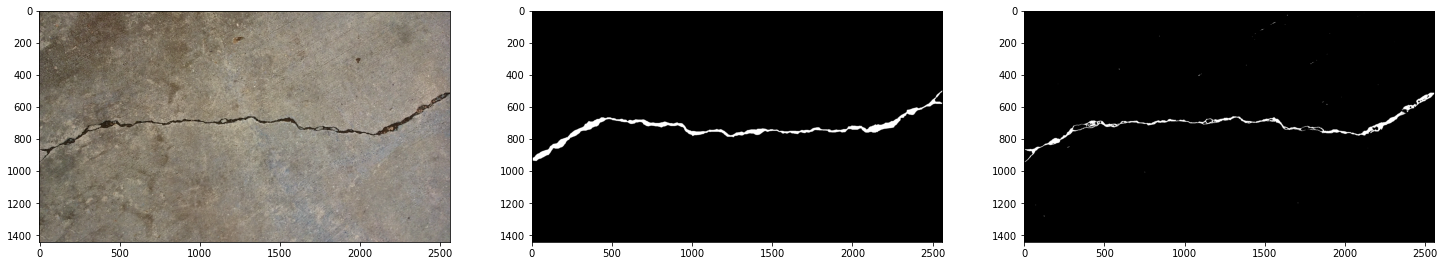

In [20]:
plt.figure(figsize=(25,15))
plt.axis=("off")
plt.subplot(131)
plt.imshow(img.permute(1,2,0).int())
plt.subplot(132)
plt.imshow(mask, cmap='gray')
plt.subplot(133)
plt.imshow(output, cmap='gray')